# Visual Art Generation & Optimizer Comparison
### (Deep learning using Keras & Tensorboard)


** Convolutional Neural Networks has many hidden layers: ** 

    The first hidden layers might only learn local edge patterns. 
    Then, each subsequent layer (or filter) learns more complex representations. 
    Finally, the last layer can classify the image as a cat or kangaroo. 
    
    
**Keras selected for deep learning library since it allows for easy and fast prototyping (through user friendliness, modularity, and extensibility), supports both convolutional networks and recurrent networks, as well as combinations of the two. Also it runs seamlessly on CPU and GPU. **

** Following Optimizer were used for comparison **

    GradientDescentOptimizer 
    AdadeltaOptimizer 
    AdagradOptimizer 
    AdamOptimizer 
    RMSPropOptimizer 
    ScipyOptimizerInterface (L-BFGS) 


Implementation of original style transfer paper (https://arxiv.org/abs/1508.06576) with improved losses from https://arxiv.org/abs/1603.08155


In [1]:
# import libraries
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import numpy as np
import pprint
import time

from PIL import Image
from functools import partial
#from importlib import reload
from numpy import eye

from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imsave
from IPython.core.debugger import Tracer
#from IPython.display import clear_output, HTML
from IPython.display import display


from utils import *

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import imagenet_utils

from keras import backend as K

#from matplotlib.pyplot import *
%matplotlib inline

Using TensorFlow backend.


### Define Global parameters  

In [2]:
# Directory path
LOGDIR = 'logs' # tensorboard log path
OUTDIR = 'results' # output images & file
INDIR  = 'images'  # input directory

# define diffrent weights - How much content, style and total variance loss 
#   contribute to the total loss.
content_weight = 1e3
style_weight = 1e5
tv_weight =  1e-3

# Use a large learning rate to change the initial image sufficiently
learning_rate = 10

# num_iterations to be used
num_iterations = 400
print_ntimes = 5

### Define variables for Image loading

In [3]:
# Define Output image size & constant
image_size = (300, 300)
num_of_color_channels = 3  # 3 for RGB
total_pixels = 256

### Define Load & Randomize Image functions

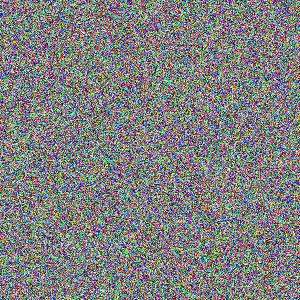

In [4]:
def load_image(size, filename=None):
    '''Load image from disc and return it as np array. 
        Args:
            size: The desired dimensions of the output image.
            filename: The fullpath to the image to load.
    '''
    width, height = size

    if not filename:
        raise ValueError(
            'If not generating random noise image, image filename is required.')
        
    # Load picture from the file
    img = PIL.Image.open(filename)
    img = img.resize((width, height))
    img_array = np.asarray(img.copy())
    return img_array

def randomize_image(size,random_noise):
    '''Generate a random noise image and return it as np array. 
        Args:
            size:   The desired dimensions of the output image.
            random_noise: Whether to generate a random noise 
                           image or to load a picture.
        Return : 
    '''
    width, height = size
    # Generate a random noise image
    # 3 is the number of channels (RGB) in the image.
    if random_noise:
        img = np.random.random(size=(width, height, num_of_color_channels))
    else:
        color = (255, 0, 0)
        img = Image.new("RGB", size=(width, height, color))
        
    # convert into array
    img_array = img * total_pixels
    return img_array


# Get and displaying image
image = randomize_image(size=image_size, random_noise=True)
show(image)

### Allow GPU memory growth

In [5]:
graph = tf.Graph()

# allocate only as much GPU memory based on runtime allocations
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

### Create a TensorFlow session and register it with Keras

In [6]:
#sess = tf.Session(config=config)
sess = tf.InteractiveSession(graph=graph, config=config)
K.set_session(sess)
#graph = sess.graph

# Keras learning phase (a scalar TensorFlow tensor) via the Keras backend
# pass the value "1" (training mode) or "0" (test mode) to feed_dict
K.set_learning_phase(0)

# define Tensorboard writer
writer = tf.summary.FileWriter(LOGDIR, graph)


### Setup Keras Model

** You can also use below library for this **

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [7]:
def setup_model(initial_img, model_name='Inception5h'):
    '''Load the model. Use a TF tensor as input just for fun.
    Args: 
        initial_imge: The initial value of the input tensor. Mainly used for size.
        model_name: Whether to normalize the input image.
    Returns:
        Tuple of (model, # The loaded keras model
            input_tensor, # The tensor that feeds the model
            content_layers, # The content layers of this model as tensors
            style_layers, # The style layers of this model as tensors
            preprocess_img, # Preprocesses an image for the model
            deprocess_img # Returns preprocessed image back to normal.
    '''
    # Prepare tensor for input image
    image_tensor = tf.Variable(initial_img)

    if model_name == 'VGG16' or model_name == 'VGG19':
        # Both models are similar
        if model_name == 'VGG16':
            # VGG 16 model
            model = VGG16(include_top=False, weights='imagenet',
                          input_tensor=image_tensor)
        elif model_name == 'VGG19':
            # VGG 19 model
            model = VGG19(include_top=False, weights='imagenet',
                          input_tensor=image_tensor)

        # Preprocesses an image for the model processing
        def preprocess_img(p):
            x = p.copy().astype(float)
            rank = len(x.shape)
            if (rank == 3):
                # Add extra batch dimension
                x = np.expand_dims(x, axis=0)
            x[:, :, :, 2] -= 103.939
            x[:, :, :, 1] -= 116.779
            x[:, :, :, 0] -= 123.68

            # Flip the channels from RGB to BGR
            x = x[:, :, :, ::-1]
            return x

        # Returns preprocessed image back to normal.
        def deprocess_img(p):
            x = np.asarray(p).copy()
            rank = len(x.shape)
            if (rank == 4):
                # Remove extra batch dimension
                x = np.squeeze(x, axis=0)

            # Flip the channels from BGR to RGB
            x = x[:, :, ::-1]

            # Remove zero-center by mean pixel
            x[:, :, 2] += 103.939
            x[:, :, 1] += 116.779
            x[:, :, 0] += 123.68

            x = np.clip(x, 0, 255).astype('uint8')
            return x

        # Define the style layers
        style_layers = [model.get_layer('block1_conv1').output,
                        model.get_layer('block2_conv1').output,
                        model.get_layer('block3_conv1').output,
                        model.get_layer('block4_conv1').output,
                        model.get_layer('block5_conv1').output]

        # Define the content layers
        content_layers = model.get_layer('block4_conv2').output

    # TODO: Add other models

    return model, image_tensor, content_layers, style_layers, preprocess_img, deprocess_img

with graph.as_default():
    with graph.name_scope("model") as scope:
        # Use the image size (with a batch dimension) to feed the model input.
        # We do so that the input has size and the convolutional layers
        # will be sized as well.
        initial = np.expand_dims(image, axis=0).astype('float32')

        # Setup the model with VGG19
        (model, input_tensor, content_layers, style_layers,
           preprocess, deprocess) = setup_model(
                            initial_img=initial,
                            model_name='VGG19')

### Verify the Model

In [8]:
# Check 
(model, input_tensor, content_layers, style_layers, preprocess, deprocess)

(<keras.engine.training.Model at 0x7ff1d8031be0>,
 <tf.Variable 'model/Variable:0' shape=(1, 300, 300, 3) dtype=float32_ref>,
 <tf.Tensor 'model/block4_conv2/Relu:0' shape=(1, 37, 37, 512) dtype=float32>,
 [<tf.Tensor 'model/block1_conv1/Relu:0' shape=(1, 300, 300, 64) dtype=float32>,
  <tf.Tensor 'model/block2_conv1/Relu:0' shape=(1, 150, 150, 128) dtype=float32>,
  <tf.Tensor 'model/block3_conv1/Relu:0' shape=(1, 75, 75, 256) dtype=float32>,
  <tf.Tensor 'model/block4_conv1/Relu:0' shape=(1, 37, 37, 512) dtype=float32>,
  <tf.Tensor 'model/block5_conv1/Relu:0' shape=(1, 18, 18, 512) dtype=float32>],
 <function __main__.setup_model.<locals>.preprocess_img>,
 <function __main__.setup_model.<locals>.deprocess_img>)

In [9]:
# Summary of the model layers
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 300, 300, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (1, 300, 300, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (1, 300, 300, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (1, 150, 150, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (1, 150, 150, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (1, 150, 150, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (1, 75, 75, 128)          0         
__________

In [10]:
# Print all operations in the graph so far
print('\n'.join([op.name for op in graph.get_operations()]))

model/Variable/initial_value
model/Variable
model/Variable/Assign
model/Variable/read
model/block1_conv1/random_uniform/shape
model/block1_conv1/random_uniform/min
model/block1_conv1/random_uniform/max
model/block1_conv1/random_uniform/RandomUniform
model/block1_conv1/random_uniform/sub
model/block1_conv1/random_uniform/mul
model/block1_conv1/random_uniform
model/block1_conv1/kernel
model/block1_conv1/kernel/Assign
model/block1_conv1/kernel/read
model/block1_conv1/Const
model/block1_conv1/bias
model/block1_conv1/bias/Assign
model/block1_conv1/bias/read
model/block1_conv1/convolution/Shape
model/block1_conv1/convolution/dilation_rate
model/block1_conv1/convolution
model/block1_conv1/BiasAdd
model/block1_conv1/Relu
model/block1_conv2/random_uniform/shape
model/block1_conv2/random_uniform/min
model/block1_conv2/random_uniform/max
model/block1_conv2/random_uniform/RandomUniform
model/block1_conv2/random_uniform/sub
model/block1_conv2/random_uniform/mul
model/block1_conv2/random_uniform
mod

## Steps for Generating Style transfer - Using Keras

### Tasks
1. Load the style and content images (optional - reserve content color).
2. Compute the style layer activations of the style input image, 
and the content layer activations of the content input image.
3. Define Style difference (loss) between current image and style input image.
4. Define Content differnce (loss) between current image and content image.
5. Define Total variance loss (prevents noise in result).
6. Define the gradient to change a result image to minimize 
the total loss = style loss + content loss + total variance loss
7. Modify the result image by the gradient for a number of iterations.

### Step 1 
Load the style and the content image.

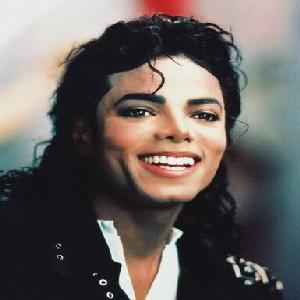

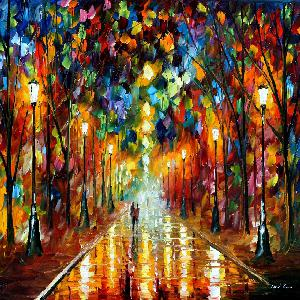

In [11]:
# Image to define the content
content_image = load_image(size=image_size, filename='images/MJ.jpg')
show(content_image)
                           
# Image which will define the style
style_image = load_image(size=image_size, filename='images/style_3.jpg') 
show(style_image)


## Step 2
Compute the style layers activations of the style input image, 
and the content layer activations of the content input image.

In [12]:
# Compute the style activations
style_layers_computed = sess.run(
    style_layers,
    feed_dict={input_tensor: preprocess(style_image)})

# Compute the content activations
content_layers_computed = sess.run(
    content_layers,
    feed_dict={input_tensor: preprocess(np.expand_dims(content_image, 0))})

## Step 3 
Define Difference (loss) between style layers of resulting image and style layers of style image

In [13]:
def style_loss(current_tensor, computed_ary):
    '''Define the style loss between a tensor and an np array.
    Args:
        current_tensor: tf.Tensor. The style activations of the current image.
        computed_ary: np array. The style activations of the style input image.
    '''
    style_losses = []
    # For each layer
    for layer1, layer2 in zip(current_tensor, computed_ary):
        _, height, width, number = map(lambda i: i, layer2.shape)
        size = height * width * number

        # Compute layer1 Gram matrix
        feats1 = tf.reshape(layer1, (-1, number))
        layer1_gram = tf.matmul(tf.transpose(feats1), feats1) / size
        
        # Compute layer2 Gram matrix
        feats2 = tf.reshape(layer2, (-1, number))
        layer2_gram = tf.matmul(tf.transpose(feats2), feats2) / size

        dim1, dim2 = map(lambda i: i.value, layer1_gram.get_shape())
        loss = tf.sqrt(tf.reduce_sum(
                         tf.square((layer1_gram - layer2_gram) / (number * number))))
        style_losses.append(loss)
    return tf.add_n(style_losses)

## Step 4
Difference (loss) between content layers of result image and content layers of content image.

In [14]:
def content_loss(current_tensor, computed_ary):
    '''Define the content loss between a tensor and an np array.
    Args:
        current_tensor: tf.Tensor. The content activations of the current image.
        computed_ary: np array. The content activations of the computed image.
    '''
    # Only for a single layer hence no loop
    _, height, width, number = computed_ary.shape
    size = height * width * number
    return tf.sqrt(tf.nn.l2_loss(current_tensor - computed_ary) / size)

## Step 5
Total variation loss, designed to keep the generated image locally coherent.
https://en.wikipedia.org/wiki/Total_variation_denoising


In [15]:
def total_variation_loss(image_tensor, image_shape=None):
    '''Define the total variation loss of the image using array or tensor
    Args:
        image_tensor: tf.Tensor. 
        image_shape: np array
    '''
    if image_shape:
        width, height, channels = image_shape
    else:
        # Try to get the image size from the tensor
        dims = image_tensor.get_shape()
        width = dims[1].value
        height = dims[2].value
        channels = dims[3].value

    # calculate x & y dimension
    tv_x_size = width * (height - 1) * channels
    tv_y_size = (width - 1) * height * channels

    return (
        tf.reduce_sum(tf.abs(image_tensor[:, 1:, :, :] - image_tensor[:, :-1, :, :])) +
        tf.reduce_sum(tf.abs(image_tensor[:, :, 1:, :] - image_tensor[:, :, :-1, :]))
    )

## Step 6.
Define the gradient to change a result image


In [16]:
def setup_gradient(input_tensor, result_tensor):
    '''Setup the gradient of the input tensor w.t.r to the result tensor.
    Args: 
        input_tensor: The input features tensor.
        result_tensor: The tensor that we want to maximize.
    '''
    # First get the result tensor mean
    excitement_score = tf.reduce_mean(result_tensor)

    # Calculate gradients on sigle image
    # Gradients give us how to change the input (input_tensor)
    # to increase the excitement_score.
    # 
    gradient = tf.gradients(excitement_score, input_tensor)[0]

    # Normalize the gradient by its L2 norm.
    # Disabled for now.
    gradient /= (tf.sqrt(tf.reduce_mean(tf.square(gradient)))  + 1e-5)

    return gradient, excitement_score



# Set up the style, content, total variation, as well as total loss
# and use them to define the gradient.
with graph.as_default():
    with graph.name_scope("style_loss") as scope:
        style_loss_op = style_weight * \
            style_loss(style_layers, style_layers_computed)
    with graph.name_scope("content_loss") as scope:
        content_loss_op = content_weight * \
            content_loss(content_layers, content_layers_computed)
    with graph.name_scope("total_variation_loss") as scope:
        tv_loss_op = tv_weight * total_variation_loss(input_tensor)
    with graph.name_scope("loss") as scope:
        total_loss_op = style_loss_op + content_loss_op + tv_loss_op
    with graph.name_scope("gradient") as scope:
        gradient_op, score_op = setup_gradient(input_tensor, total_loss_op)
        
    ##
    with graph.name_scope("summaries") as scope:
        tf.summary.scalar("content_loss", content_loss_op)
        tf.summary.scalar("style_loss", style_loss_op)
        tf.summary.scalar("total_variation_loss", tv_loss_op)
        tf.summary.histogram("Histogram_loss", total_loss_op)
        tf.summary.histogram("Histogram_content_loss", content_loss_op)
        tf.summary.histogram("Histogram_style_loss", style_loss_op)
        #tf.summary.image()
                           
# merge all summaries
summary_op = tf.summary.merge_all()

## Step 7
Modify the resulting image of the style transfer by the gradient.

### Define common functions used to run optimization

In [17]:
def get_uninitialized_variables(variables=None, session=None):
    """
    Get uninitialized variables in a session as a list.
        Args: 
            variables: list of tf.Variable. Get uninitiliazed vars 
                from these. If none, gets all uinitialized vars in session.
            session: tf.Session to find uninitialized vars in. If none
                uses default session.
        Returns:
            Uninitialized variables within `variables`.
            If `variables` not specified, return all uninitialized variables.
    """
    if not session:
        session = tf.get_default_session()
    if variables is None:
        variables = tf.global_variables()
    else:
        variables = list(variables)
        
    init_flag = session.run(
        tf.stack([tf.is_variable_initialized(v) for v in variables]))
    return [v for v, f in zip(variables, init_flag) if not f]


def initialize_variables():
    ''' Initialize the internal variables the optimizer uses.
         We could do tf.global_variables_initializer().eval() to 
          initialize all variables but this messes up the keras model.'''
    # Get uninitialized vars and their initializers
    uninitialized_vars = get_uninitialized_variables()
    initializers = [var.initializer for var in uninitialized_vars]

    # Print uninitialized variables
    print('Uninitialized variables:')
    print([initializer.name for initializer in initializers])

    # Initialize the variables
    _ = [initializer.run() for initializer in initializers]


def initialize_input(show_image=False):
    ''' Define start image in the input tensor.
        The image to start with is the content image with random peturbations
           (required, otherwise TV loss converges to nan).
    Args:
        show_image: Whether to display the generated image.
    '''
    # Define random 0 to 1 image with size (batch_size, image_size, channels)
    #             mean=0.5, stddev=.5
    initial_random = tf.random_normal(
        mean=1, stddev=.01, shape=(1,) + image_size + (3,))

    # Use the content image as start image for input_tensor
    initial_content = preprocess(np.expand_dims(content_image, axis=0))

    # Init the input tensor with initial_content
    input_tensor.initializer.run()
    input_tensor.assign(
        tf.clip_by_value(initial_content * initial_random, 0, 255) ).eval()

    # Show the input tensor
    if show_image:
        show(np.squeeze(input_tensor.eval()))

# Helper to print the losses.
def print_progress(i,
                   iterations,
                   loss_computed,
                   style_loss_computed,
                   content_loss_computed,
                   tv_loss_computed):
    print('Iteration %d/%d Content L: %g Style L: %g TV L: %g Total L: %g' % (
        i,
        iterations,
        content_loss_computed,
        style_loss_computed,
        tv_loss_computed,
        loss_computed
    ))


def run_optimization(train_step, iterations=100, print_n_times=10):
    ''' Run the optimization for a number of iterations. 
    Args:
        train_step: The op that gets executed every iteration.
        iterations: How many times to run the optimization. Recommended at
            least 500 - 1000 iterations for a good quality image. Good style
            should be visible even after 100 iters.
        print_n_times: Int, How many times to print the progress.
    Return:
        A list of losses during the optimization like so:
        [(time elapsed, loss)]
    '''
    if print_n_times == 0:
        # Dont print at all
        print_every_n = iterations + 1
    else:
        print_every_n = max(iterations // print_n_times, 1)

    # Keep only the image with the lowest loss (in case we converge).
    best_loss = float('inf')
    best = None

    losses = []
    c_image = np.clip(preprocess(content_image), 0, 255)

    # To compute total optimization time
    start_time = time.time()

    # Optimization loop
    for i in range(iterations):
        # Keep the input_tensor between 0 and 255
        # (gives slightly better output, slows optimization by factor of 2)
#         input_tensor.assign(tf.clip_by_value(input_tensor, 0, 255)).eval()
        
        # Run the training (train_step), and get the losses
        (_, result_image, loss_computed,
             style_loss_computed, content_loss_computed, tv_loss_computed,
               summary_str) = sess.run(
                    [train_step, input_tensor, score_op, style_loss_op, content_loss_op,
                     tv_loss_op, summary_op])

        output_img = input_tensor.eval()
        output_img = np.clip(output_img, 0, 255)
        #output_img1=color_transfer(output_img,c_image)
        #assign_op = input_tensor.assign(output_img1)
        #sess.run(assign_op)
        #print ('value = ', input_tensor.value)
        
        wall_time = time.time() - start_time
        losses.append((wall_time, loss_computed))

        # write log
        writer.add_summary(summary_str, i)
        
        # Print progress
        if i % print_every_n == 0:
            print_progress(i, iterations, loss_computed,
                           style_loss_computed, content_loss_computed,
                           tv_loss_computed)

        # skip this for now.
        # if loss_computed < best_loss:
        #    best_loss = loss_computed
        #    best = result_image

    total_time = time.time() - start_time
    print ('Model Training took {:.0f} seconds or {:.2f} s/iteration !'.format(
        wall_time,
        wall_time / iterations))

    return losses

### Define wrapper function to call run_optimization

In [18]:
def optimize_model(optimizer, iterations=100, new_image=True):
    ''' Define and run the optimization for a given optimizer
    Args:
        optimizer: The optimizer to use.
        iterations: Number of times to run optimizer.
        new_image: Whether to start with a new image, or continue with the 
            previous one.
    Return: A tuple: 
        A list of losses during the optimization like so: [(time elapsed, loss)]
        The image
    '''
    with graph.as_default():
        # Compute the gradients for a list of variables.
        grads_and_vars = optimizer.compute_gradients(score_op, [input_tensor])
        # Op that ask the optimizer to apply the gradients.
        train_step = optimizer.apply_gradients(grads_and_vars)

        # initialize variables
        initialize_variables()
        
        # if new image then initialize input
        if new_image:
            initialize_input()
        
        # get losses after running optimization
        losses = run_optimization(
            train_step, iterations=iterations, print_n_times=print_ntimes)
        
        # print resulting image
        result_image = input_tensor.eval()
        result_image = np.clip(deprocess(result_image), 0, 255)
        show(result_image)
        return losses, result_image

### Define function to save results of an optimizer run (e.g. image, csv)

In [19]:
def store_results(optimizer_name, loss=None, output_image=None):
    ''' A helper to save the results of this optimizer run
    Args:
        optimizer_name: The optimizer name to store the results for.
        loss: losses during the optimization run
        output_image: Result image
    '''
    if output_image is not None:
        imsave(OUTDIR+'/{}.jpg'.format(optimizer_name), output_image)
    if loss is None:
        # Load the loss
        loss = np.loadtxt(OUTDIR+'/' + optimizer_name + '.csv')
    else:
        # Save the loss
        loss = np.asarray(loss)
        np.savetxt(OUTDIR+ '/' + optimizer_name + '.csv', np.asarray(loss))
    plot, = plt.plot(loss[:, 0], loss[:, 1])
    plotHandles.append(plot)
    labels.append(optimizer_name)         

## Run different optimizers for Loss comparison & Visualize

1. GradientDescentOptimizer 
2. AdadeltaOptimizer
3. AdagradOptimizer 
4. AdamOptimizer 
5. RMSPropOptimizer
6. ScipyOptimizerInterface (L-BFGS)

In [20]:
# Turn interactive plotting off
plt.ioff()

# display a legend in the plot
figure = plt.figure(figsize=(10, 10))
labels = []
plotHandles = []

GradientDescentOptimizer
Uninitialized variables:
[]
Iteration 0/400 Content L: 312007 Style L: 1.08096e+06 TV L: 1275.8 Total L: 1.39424e+06
Iteration 80/400 Content L: 497438 Style L: 274363 TV L: 9626.67 Total L: 781428
Iteration 160/400 Content L: 501983 Style L: 199625 TV L: 10140.4 Total L: 711748
Iteration 240/400 Content L: 501518 Style L: 169121 TV L: 10198.5 Total L: 680838
Iteration 320/400 Content L: 497378 Style L: 153460 TV L: 10204.3 Total L: 661043
Model Training took 663 seconds or 1.66 s/iteration !


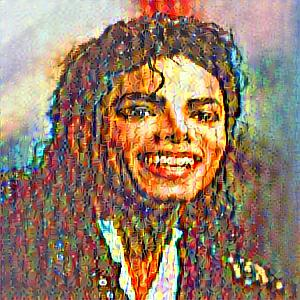

In [21]:
print('GradientDescentOptimizer')
hparam = '/GradientDescentOptimizer'
writer = tf.summary.FileWriter(LOGDIR + hparam)   

model = tf.train.GradientDescentOptimizer(learning_rate)
loss, stlyed_image = optimize_model(model, num_iterations)
store_results(model.get_name(), loss, stlyed_image)

writer.add_graph(sess.graph)


AdadeltaOptimizer
Uninitialized variables:
['model/Variable/Adadelta/Assign', 'model/Variable/Adadelta_1/Assign']
Iteration 0/400 Content L: 311996 Style L: 1.08098e+06 TV L: 1274.81 Total L: 1.39425e+06
Iteration 80/400 Content L: 295709 Style L: 1.07947e+06 TV L: 1340.7 Total L: 1.37652e+06
Iteration 160/400 Content L: 285601 Style L: 1.07769e+06 TV L: 1409.15 Total L: 1.3647e+06
Iteration 240/400 Content L: 275794 Style L: 1.07559e+06 TV L: 1487.56 Total L: 1.35287e+06
Iteration 320/400 Content L: 266153 Style L: 1.07315e+06 TV L: 1573.7 Total L: 1.34087e+06
Model Training took 661 seconds or 1.65 s/iteration !


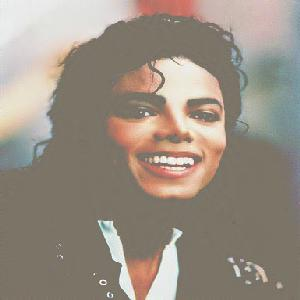

In [22]:
print('AdadeltaOptimizer')

hparam = '/AdadeltaOptimizer'
writer = tf.summary.FileWriter(LOGDIR + hparam)   

model = tf.train.AdadeltaOptimizer(learning_rate)
loss, stlyed_image = optimize_model(model, num_iterations)
store_results(model.get_name(), loss, stlyed_image)

writer.add_graph(sess.graph)

AdagradOptimizer
Uninitialized variables:
['model/Variable/Adagrad/Assign']
Iteration 0/400 Content L: 311916 Style L: 1.081e+06 TV L: 1275.93 Total L: 1.39419e+06
Iteration 80/400 Content L: 507897 Style L: 223449 TV L: 11056.5 Total L: 742403
Iteration 160/400 Content L: 503279 Style L: 173310 TV L: 11071.6 Total L: 687661
Iteration 240/400 Content L: 500644 Style L: 151845 TV L: 10969.8 Total L: 663459
Iteration 320/400 Content L: 497018 Style L: 141273 TV L: 10869.8 Total L: 649160
Model Training took 663 seconds or 1.66 s/iteration !


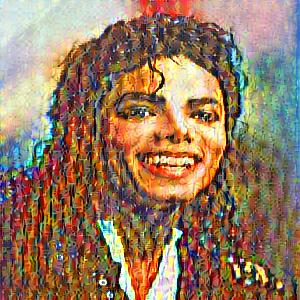

In [23]:
print('AdagradOptimizer')
hparam = '/AdagradOptimizer'
writer = tf.summary.FileWriter(LOGDIR + hparam)   

model = tf.train.AdagradOptimizer(learning_rate)
loss, stlyed_image = optimize_model(model, num_iterations)
store_results(model.get_name(), loss, stlyed_image)

writer.add_graph(sess.graph)

AdamOptimizer
Uninitialized variables:
['beta1_power/Assign', 'beta2_power/Assign', 'model/Variable/Adam/Assign', 'model/Variable/Adam_1/Assign']
Iteration 0/400 Content L: 312023 Style L: 1.08095e+06 TV L: 1275.54 Total L: 1.39425e+06
Iteration 80/400 Content L: 497329 Style L: 103288 TV L: 12211.6 Total L: 612829
Iteration 160/400 Content L: 493691 Style L: 87016.2 TV L: 10673.4 Total L: 591380
Iteration 240/400 Content L: 480591 Style L: 92854 TV L: 10175.6 Total L: 583621
Iteration 320/400 Content L: 479363 Style L: 93256.3 TV L: 9962.44 Total L: 582582
Model Training took 666 seconds or 1.66 s/iteration !


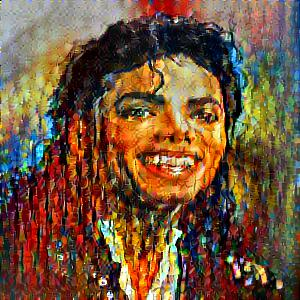

In [24]:
print('AdamOptimizer')
hparam = '/AdamOptimizer'
writer = tf.summary.FileWriter(LOGDIR + hparam)   

model = tf.train.AdamOptimizer(learning_rate)
loss, stlyed_image = optimize_model(model,num_iterations)
store_results(model.get_name(), loss, stlyed_image)

writer.add_graph(sess.graph)

RMSPropOptimizer
Uninitialized variables:
['model/Variable/RMSProp/Assign', 'model/Variable/RMSProp_1/Assign']
Iteration 0/400 Content L: 311996 Style L: 1.081e+06 TV L: 1275.89 Total L: 1.39427e+06
Iteration 80/400 Content L: 538179 Style L: 243082 TV L: 12861.4 Total L: 794123
Iteration 160/400 Content L: 506143 Style L: 239194 TV L: 13120.4 Total L: 758457
Iteration 240/400 Content L: 504171 Style L: 238385 TV L: 13150.4 Total L: 755706
Iteration 320/400 Content L: 502018 Style L: 204701 TV L: 13369.1 Total L: 720088
Model Training took 600 seconds or 1.50 s/iteration !


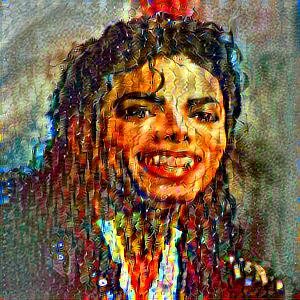

In [25]:
print('RMSPropOptimizer')
hparam = '/RMSPropOptimizer'
writer = tf.summary.FileWriter(LOGDIR + hparam)   

model = tf.train.RMSPropOptimizer(learning_rate)
loss, stlyed_image = optimize_model(model, num_iterations)
store_results(model.get_name(), loss, stlyed_image)

writer.add_graph(sess.graph)

### L-BFGS Optimizer

In tensorflow L-BFGS is just a wrapper around the python L-BFGS, just itself is 
a wrapper around a Fortran implementation of L-BFGS, so the procedure is a bit 
different than the other optimizers.

ScipyOptimizerInterface
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 573550.562500
  Number of iterations: 401
  Number of functions evaluations: 408


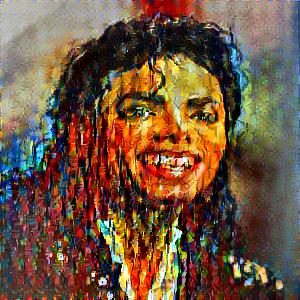

<bound method FileWriter.close of <tensorflow.python.summary.writer.writer.FileWriter object at 0x7ff158680c50>>

In [26]:
print('ScipyOptimizerInterface')
hparam = '/ScipyOptimizerInterface'
writer = tf.summary.FileWriter(LOGDIR + hparam)   

with graph.as_default():
    initialize_input()
    iterations = num_iterations
    
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(
        score_op,
        var_list=[input_tensor],
        options={'maxiter': iterations})

    def step_callback(x):
        pass
        # Keep the input_tensor between 0 and 255
        # (gives slightly better output, slows optimization by factor of 2)
#         x = x.astype('float32').reshape((1,) + image_size + (3,))
#         x = input_tensor.assign(tf.clip_by_value(x, 0, 255)).eval()
        # Show the image at this iteration
        # show(np.reshape(x, image_size + (3,)))

    def loss_callback(*args):
        wall_time = time.time() - start_time
        losses.append((wall_time, args[0]))

    losses = []
    start_time = time.time()

    # minimize function
    optimizer.minimize(
        sess,
        #         feed_dict=[input_tensor],
        fetches=[score_op, style_loss_op, content_loss_op, tv_loss_op, summary_op],
        step_callback=step_callback,
        loss_callback=loss_callback
    )

    stlyed_image = input_tensor.eval()
    stlyed_image = np.clip(deprocess(stlyed_image), 0, 255)
    show(stlyed_image)
    store_results('L-BFGS', losses, stlyed_image)
    writer.add_graph(sess.graph)
    
writer.close

### Visualize & Compare loss Vs wall time for each Optimizers 

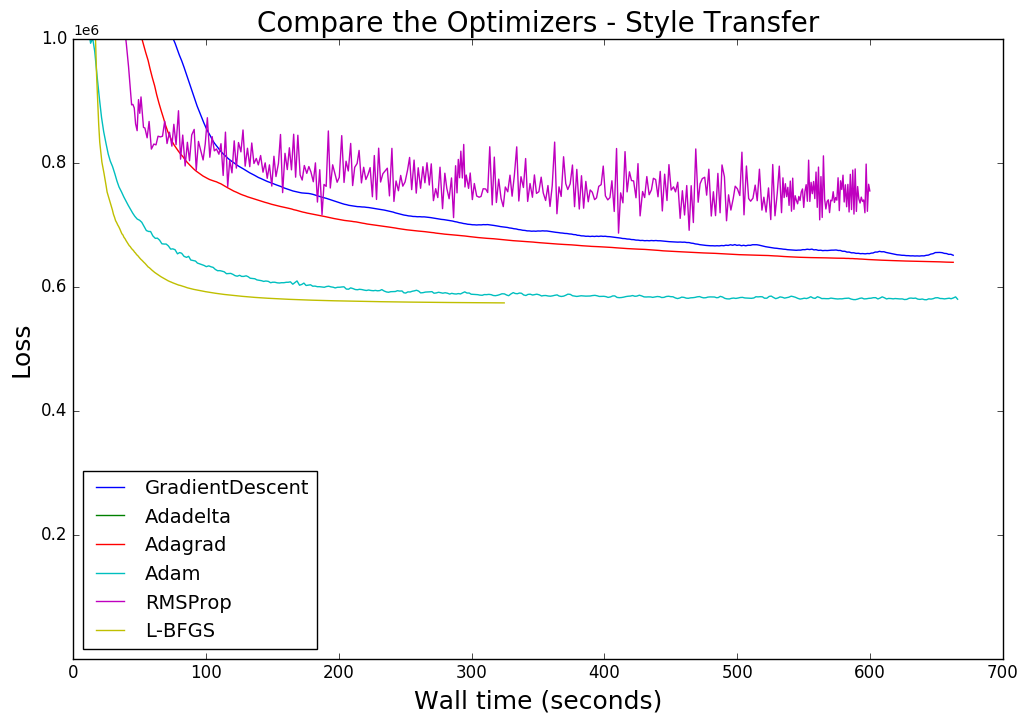

In [27]:
# Plot the Comparison of loss Vs wall time
figure.set_size_inches(12, 8, forward=True)
plt.legend(plotHandles, labels, prop={'size': 14}, loc='best')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.tick_params(labelsize=12)
plt.xlabel('Wall time (seconds)', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.ylim([0.2, 1e+6])
plt.title('Compare the Optimizers - Style Transfer', fontsize=20)

figure